In [36]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#keras imports
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda

In [99]:
#read dfs
shared_articles_df = pd.read_csv('shared_articles.csv')
#shared_articles_df.rename({'contentId':'content'}, axis='columns', inplace=True) 
#print(shared_articles_df.columns)
users_interactions_df = pd.read_csv('users_interactions.csv')

Index(['timestamp', 'eventType', 'content', 'authorPersonId',
       'authorSessionId', 'authorUserAgent', 'authorRegion', 'authorCountry',
       'contentType', 'url', 'title', 'text', 'lang'],
      dtype='object')


In [3]:
#set scores for differnt types of interactions
event_type_score = {
   'VIEW': 1.0,
   'LIKE': 4.0, 
   'COMMENT CREATED': 10.0,
   'FOLLOW': 25.0,
   'BOOKMARK': 100.0,
}

users_interactions_df['eventScore'] = users_interactions_df['eventType'].apply(lambda x: event_type_score[x])

In [4]:
users_interactions_count_df = users_interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('Total no. of users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('No. of users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

Total no. of users: 1895
No. of users with at least 5 interactions: 1140


In [5]:
print('# of interactions: %d' % len(users_interactions_df))
interactions_from_selected_users_df = users_interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


# Final Processed df

In [6]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventScore'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# of unique user/item interactions: 39106


,personId,contentId,eventScore
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


In [14]:
user_enc = LabelEncoder()
interactions_full_df['person'] = user_enc.fit_transform(interactions_full_df['personId'].values)
n_users = interactions_full_df['person'].nunique()

item_enc = LabelEncoder()
interactions_full_df['content'] = item_enc.fit_transform(interactions_full_df['contentId'].values)
n_content = interactions_full_df['content'].nunique()

interactions_full_df['eventScore'] = interactions_full_df['eventScore'].values.astype(np.float32)
min_score = min(interactions_full_df['eventScore'])
max_score = max(interactions_full_df['eventScore'])
n_users, n_content, min_score, max_score

#drop the id columns from df
interactions_full_df = interactions_full_df.drop(columns=['personId', 'contentId'])

# Train Test Split

In [29]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['person'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

X_train,X_test,y_train,y_test = interactions_train_df.drop(columns=['eventScore']), interactions_test_df.drop(columns=['eventScore']),\
                                interactions_train_df['eventScore'], interactions_test_df['eventScore']

X_train,X_test,y_train,y_test = X_train.values,X_test.values,y_train.values,y_test.values 
print(len(X_train),len(y_train),len(X_test),len(y_test))

# interactions on Train set: 31284
# interactions on Test set: 7822
31284 31284 7822 7822


In [30]:
#set n_factors for matrix factorisation
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Basic deep learning model for recommendations

In [31]:
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [32]:
model = RecommenderV1(n_users, n_content, n_factors)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        57000       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        149200      input_4[0][0]                    
____________________________________________________________________________________________

In [33]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/home/vijay/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 31284 samples, validate on 7822 samples
Epoch 1/5
31284/31284 [==============================] - 5s 162us/step - loss: 5.6054 - val_loss: 5.4816
Epoch 2/5
31284/31284 [==============================] - 5s 160us/step - loss: 5.4269 - val_loss: 5.2164
Epoch 3/5
31284/31284 [==============================] - 5s 153us/step - loss: 4.9249 - val_loss: 4.5910
Epoch 4/5
31284/31284 [==============================] - 6s 179us/step - loss: 4.1890 - val_loss: 3.8779
Epoch 5/5
31284/31284 [==============================] - 7s 209us/step - loss: 3.5194 - val_loss: 3.3138


## Inference
With just a basic deep learning model trained for 5 epochs, we are able to reach a val_loss of 3.3! Let's try a more advanced deep learning model!

# Deep Learning model with non-linear activations included to bump the model performance

In [34]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [37]:
model = RecommenderV2(n_users, n_content, n_factors, min_score, max_score)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 50)        57000       input_7[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 50)        149200      input_8[0][0]                    
____________________________________________________________________________________________

In [39]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 31284 samples, validate on 7822 samples
Epoch 1/20
31284/31284 [==============================] - 6s 184us/step - loss: 5.6128 - val_loss: 5.7524
Epoch 2/20
31284/31284 [==============================] - 8s 246us/step - loss: 4.3937 - val_loss: 4.7709
Epoch 3/20
31284/31284 [==============================] - 7s 223us/step - loss: 3.5871 - val_loss: 4.1137
Epoch 4/20
31284/31284 [==============================] - 5s 154us/step - loss: 3.0323 - val_loss: 3.6630
Epoch 5/20
31284/31284 [==============================] - 5s 155us/step - loss: 2.6356 - val_loss: 3.3430
Epoch 6/20
31284/31284 [==============================] - 4s 142us/step - loss: 2.3413 - val_loss: 3.1098
Epoch 7/20
31284/31284 [==============================] - 7s 229us/step - loss: 2.1142 - val_loss: 2.9395
Epoch 8/20
31284/31284 [==============================] - 7s 232us/step - loss: 1.9330 - val_loss: 2.8132
Epoch 9/20
31284/31284 [==============================] - 4s 134us/step - loss: 1.7830 - val_loss: 2.71

## Inference
Great! We are able to reduce the val_loss to 2.44 with the advanced deep learning model. This is a significant performance improvement over the basic deep learnign model.

# Evaluation

In [61]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('person')
interactions_train_indexed_df = interactions_train_df.set_index('person')
interactions_test_indexed_df = interactions_test_df.set_index('person')

In [88]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the article information.
    interactions_df = interactions_df.rename(columns={"contentId": "content"})
    interacted_items = interactions_df.loc[person_id]['content']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [85]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(shared_articles_df['content'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['content']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['content'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['content'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['content'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['content'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

In [116]:
class DeeplearningRecommender:
    
    MODEL_NAME = 'DeepLearning'
    
    def __init__(self,items_df=None):
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        items_id_array = list(set(interactions_full_df['content']))
        user_id_array = [user_id]*len(items_id_array)
        X_test_array = [user_id_array,items_id_array]
        
        #model prediction
        y_pred = model.predict(X_test_array)
        y_pred = np.reshape(y_pred,(y_pred.shape[0],))
        
        #create recommendations_df
        recommendations_df=pd.DataFrame()
        recommendations_df['eventScore'] = y_pred
        recommendations_df['content'] = items_id_array
        #sort score by descending order to get top recommendations
        recommendations_df = recommendations_df.sort_values('eventScore', ascending = False)
        
        if verbose:
            recommendations_df = recommendations_df.merge(shared_articles_df, how = 'left', 
                                                          left_on = 'content', 
                                                          right_on = 'content')[['eventScore', 'content', 'title', 'url', 'lang']]

        return recommendations_df
    
deeplearning_model = DeeplearningRecommender(shared_articles_df)

In [117]:
print('Evaluating deep learning model....')
dl_global_metrics, dl_detailed_results_df = model_evaluator.evaluate_model(deeplearning_model)
print('\nGlobal metrics:\n%s' % dl_global_metrics)
dl_detailed_results_df.head(10)

1139 users processed

Global metrics:
{'modelName': 'DeepLearning', 'recall@5': 1.0, 'recall@10': 1.0}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,192,192,192,1.0,1.0,776
17,134,134,134,1.0,1.0,416
16,130,130,130,1.0,1.0,496
10,117,117,117,1.0,1.0,476
82,88,88,88,1.0,1.0,399
161,80,80,80,1.0,1.0,362
65,73,73,73,1.0,1.0,622
81,69,69,69,1.0,1.0,590
106,69,69,69,1.0,1.0,13
52,68,68,68,1.0,1.0,780


# RESULTS
## Great! Our deep learning model gives perfect score of 1.0 for both recall@5 and recall@10 which is significantly higher than the conventional methods such as Popularity model, Content-based model, Collaborative-Filtering model and Hybrid recommender model.

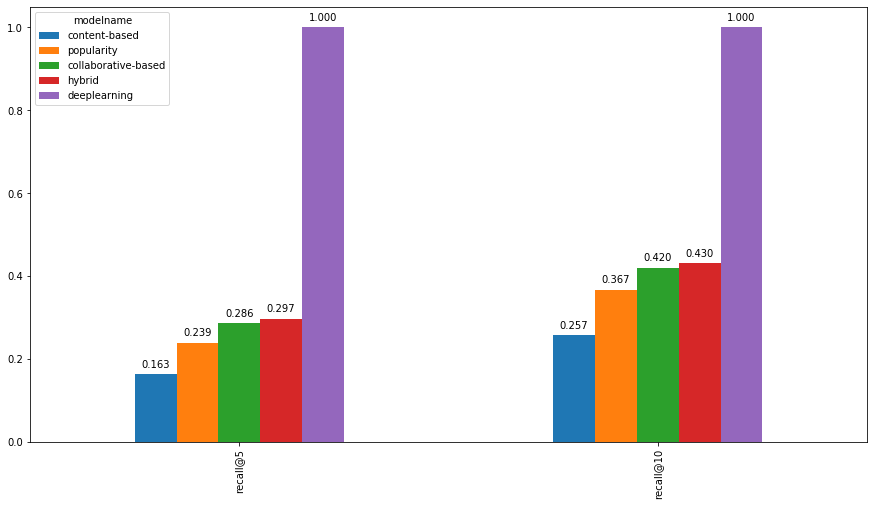

In [112]:
#writing down the results obtained from the baseline model from previous file
global_metrics_df=pd.DataFrame()
global_metrics_df['modelname'] = ['content-based', 'popularity', 'collaborative-based', 'hybrid', 'deeplearning'] 
global_metrics_df['recall@5'] = [0.163,0.239,0.286,0.297,1]
global_metrics_df['recall@10'] = [0.257,0.367,0.42,0.43,1]
global_metrics_df = global_metrics_df.set_index('modelname')

%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')